In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy import stats
from tqdm import tqdm

In [4]:
dataloader = utils.MRIDataLoader()

In [5]:
subject_ids = dataloader.get_subject_ids()
preterm_ids, fullterm_ids = dataloader.get_preterm_ids()
subject_id_default = subject_ids[fullterm_ids][0]
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
TE_times = dataloader.get_TE_times()
thresh_default = 0.9

### In each individual calculate the number of non-monotonic voxels in each tissue type
Do that with tissue type classification of 0.9, then repeat it for GM tissue type with many threshold values

In [6]:
data = dataloader.get_img(subject_id_default, 'signal').reshape((-1,10))
seg = dataloader.get_img(subject_id_default, 'seg').reshape((-1,6))

rois = ['GM', 'WM', 'CSF']
thresh_range = np.arange(start=0.05, stop=1, step=0.05)
nonmono_roi_pct = []    

for roi_list_id, roi in enumerate(rois):
    roi_id = roi_dict[roi]
    nonmono_roi_pct.append([]) 
    for sub_idx, subject_id in tqdm(enumerate(subject_ids), ascii=True, total=subject_ids.shape[0]):
        data = dataloader.get_img(subject_id, 'signal')
        seg = dataloader.get_img(subject_id, 'seg')
        is_data_nonmono = ~utils.is_monotonic_index(data)
        nonmono_roi_pct[roi_list_id].append([])
        for thresh in thresh_range:
            is_roi = seg[...,roi_id] > thresh
            nb_roi = is_roi.sum()
            nb_nonmono = is_data_nonmono[is_roi].sum()
            
            nonmono_pct = nb_nonmono / nb_roi
            nonmono_roi_pct[roi_list_id][sub_idx].append(nonmono_pct)
            # if (nonmono_pct > 0.3) and (thresh > 0.91):
            #     print(f'subject_id: {subject_id}, roi: {roi}, pct: {nonmono_pct:2%}')
nonmono_roi_pct = np.asarray(nonmono_roi_pct, dtype=object)

data = dataloader.get_img(subject_id, 'signal').reshape(-1,10)
seg = dataloader.get_img(subject_id, 'seg').reshape(-1,6)
is_data_nonmono = ~utils.is_monotonic_index(data)
is_roi = seg[...,2] > 0.9
is_roi_nonmono = is_roi * is_data_nonmono
data_nonmono = data[is_roi_nonmono]

100%|##########| 135/135 [00:30<00:00,  4.38it/s]


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_4648\406694747.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


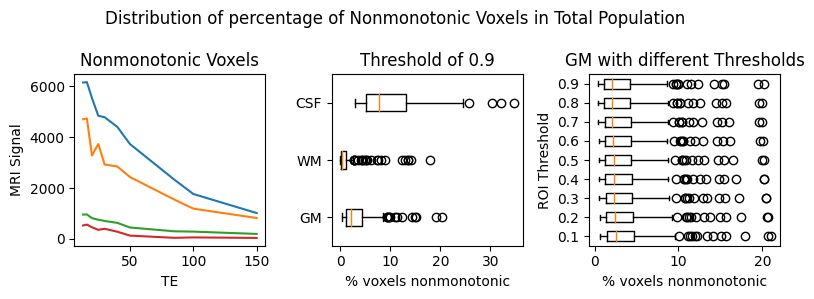

In [10]:
fig, axs = plt.subplots(1,3,figsize=(8,3))

data_list = nonmono_roi_pct[:,:,18].swapaxes(0,1)
axs[1].boxplot(data_list * 100, labels=rois, vert=False)
axs[1].set_title('Threshold of 0.9')

is_inlier = nonmono_roi_pct[0,:,0] < 0.5
nonmono_without_outlier = nonmono_roi_pct[0, is_inlier]
axs[2].boxplot(nonmono_without_outlier[:,1::2] * 100, labels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], vert=False)
axs[2].set_title('GM with different Thresholds')
axs[2].set_ylabel('ROI Threshold')
for ax in fig.axes:
    ax.set_xlabel('% voxels nonmonotonic')

for vox_id in [100,150,5,180]:
    axs[0].plot(TE_times, data_nonmono[vox_id])
    axs[0].set_title('Nonmonotonic Voxels')
    axs[0].set_xlabel('TE')
    axs[0].set_ylabel('MRI Signal')

    
fig.suptitle('Distribution of percentage of Nonmonotonic Voxels in Total Population')
fig.tight_layout()
fig.show()

### Check the kink at the beginning of the signals

In [8]:
TE_times

array([ 13.,  16.,  20.,  25.,  30.,  40.,  50.,  85., 100., 150.])

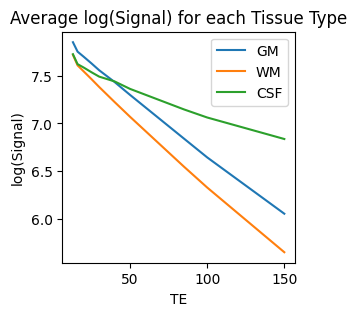

In [9]:
data = dataloader.get_img(2,'signal').reshape(-1,10)
seg = dataloader.get_img(2,'seg').reshape(-1,6)

fig = plt.figure(figsize=(3,3))

for ax_id, roi in enumerate(rois):
    roi_id = roi_dict[roi]
    is_roi = seg[:,roi_id] > thresh_default
    is_mono = utils.is_monotonic_index(data)
    is_roi_mono = is_roi * is_mono
    roi_data = data[is_roi_mono]
    roi_data_mean = np.average(roi_data, axis=0)
    
    plt.plot(TE_times, np.log(roi_data_mean), label=roi)
plt.legend()
plt.xlabel('TE')
plt.ylabel('log(Signal)')
plt.title('Average log(Signal) for each Tissue Type')
plt.show()